In [1]:
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from IPython.core import display
from utils import sample_rate, sample_space, phase_from_frequency, duration

# Shaping the Sound

We earlier discussed modulation on the whole wave but to shape a wave we need to Modulate it with time and shape the sound exactly as we need it. We do that with **Envelopes**

An envelope is a term used to describe the evolution of a sound in a piece of music, the most common envelope generator is controlled with four parameters: attack, decay, sustain and release (ADSR).



<img src="https://blog.landr.com/_next/image/?url=https%3A%2F%2Fblog-api.landr.com%2Fwp-content%2Fuploads%2F2016%2F10%2FASDR-01.jpg&w=1440&q=75" alt="ADSR Envelope" width="800" height="auto">




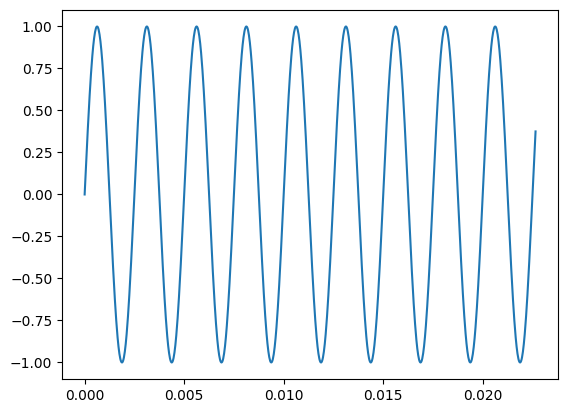

In [2]:
amplitude = 1
frequency = 400
original_wave = amplitude * np.sin(phase_from_frequency(frequency, sample_space))
plt.plot(sample_space[:1000], original_wave[:1000])

In [3]:
ipd.Audio(original_wave, rate=sample_rate)

In [4]:
total_samples = len(original_wave)
envelope = np.zeros(total_samples)
envelope

array([0., 0., 0., ..., 0., 0., 0.])

**Attack**

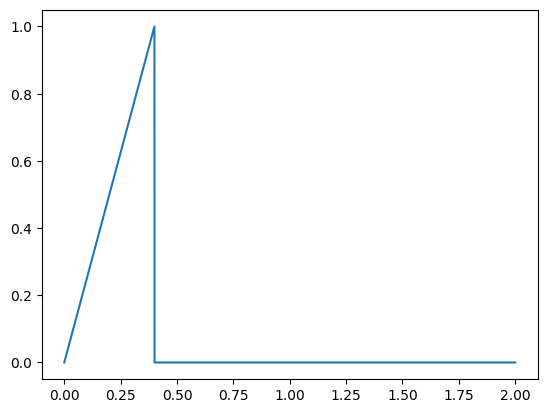

In [5]:
ATTACK_TIME = 0.4 # seconds

# Calculate the number of attack samples
attack_samples = int(ATTACK_TIME * sample_rate)

# Ramp up frpm 0 to 1 for attack_samples
envelope[0:attack_samples] = np.linspace(0, 1, attack_samples)
plt.plot(sample_space, envelope)

**Decay**

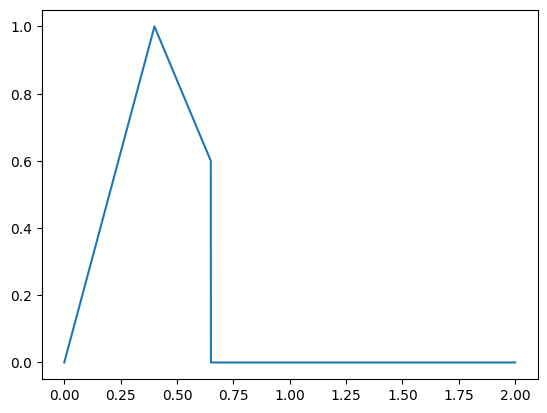

In [6]:
DECAY_TIME = 0.25 # seconds
SUSTAIN_LEVEL = 0.6 # Amplitude level (0.0 to 1.0)

# Number of decay samples
decay_samples = int(DECAY_TIME * sample_rate)

# Include attack to get the total number of samples till decay ends
decay_end_sample =  attack_samples + decay_samples

# Calculate actual number of samples available for decay
number_of_decay_samples = decay_end_sample - attack_samples

envelope[attack_samples:decay_end_sample] = np.linspace(1, SUSTAIN_LEVEL, number_of_decay_samples)

plt.plot(sample_space, envelope)

**Sustain**

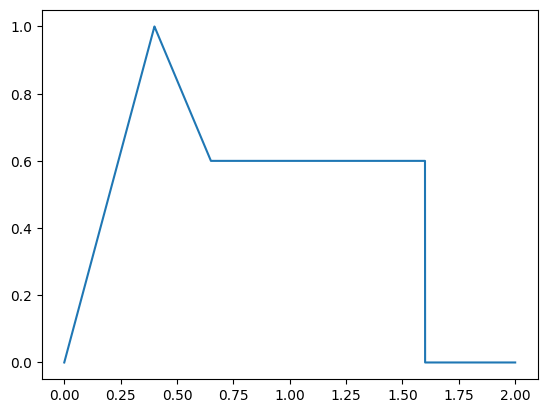

In [7]:
RELEASE_TIME = 0.4 # seconds

# Number of Release samples
release_samples = int(RELEASE_TIME * sample_rate)

# Start of Release sample
release_start_sample = total_samples - release_samples

# Fill the sustain part with the constant SUSTAIN_LEVEL
envelope[decay_end_sample:release_start_sample] = SUSTAIN_LEVEL

plt.plot(sample_space, envelope)

**Release**

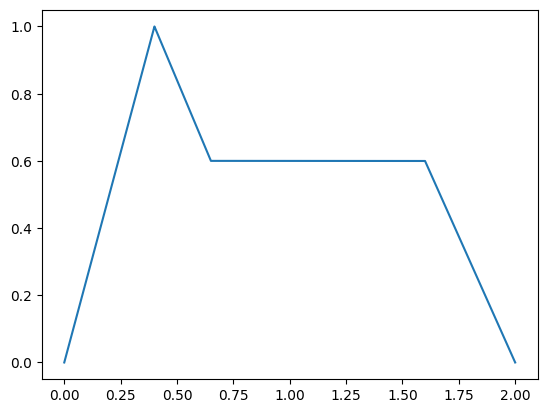

In [8]:
# Start Index of Release sample
release_start_sample = total_samples - release_samples

# Number of Release Samples
number_of_release_samples = total_samples - release_start_sample

level_before_release = envelope[release_start_sample - 1]

# Ramp down to 0 in release_samples
envelope[release_start_sample:total_samples] = np.linspace(level_before_release, 0, number_of_release_samples)

plt.plot(sample_space, envelope)

### [E] Implement Envelope Class

In [ ]:
class Envelope:
    

In [ ]:
amplitude = 0.9
frequency = 400
original_wave = amplitude * np.sin(phase_from_frequency(frequency, sample_space))
ipd.Audio(original_wave, rate=sample_rate)

In [ ]:
# Define ADSR parameters (ensure total time fits reasonably within 'duration')
attack_t = 0.4   # seconds
decay_t = 0.2    # seconds
sustain_l = 0.6  # level (60% of peak amplitude)
release_t = 0.5  # seconds

# Create an Envelope instance
adsr_envelope = Envelope(
    attack_time=attack_t,
    decay_time=decay_t,
    sustain_level=sustain_l,
    release_time=release_t,
)

In [ ]:
shaped_wave, envelope_shape = adsr_envelope.apply(original_wave)
ipd.Audio(shaped_wave, rate=sample_rate)

**Solution**

In [9]:
class Envelope:
    """
    Envelope class for ADSR.
    """
    def __init__(self, attack_time, decay_time, sustain_level, release_time, sample_rate=sample_rate):
        """
        attack_time (float): Time in seconds for the attack phase.
        decay_time (float): Time in seconds for the decay phase.
        sustain_level (float): Amplitude level (0.0 to 1.0) for the sustain phase.
        release_time (float): Time in seconds for the release phase.
        """
        self.attack_time = float(attack_time)
        self.decay_time = float(decay_time)
        self.sustain_level = float(sustain_level)
        self.release_time = float(release_time)
        self.sample_rate = sample_rate

    def apply(self, waveform):
        """
        Applies the ADSR envelope om waveform.
        """
        total_samples = len(waveform)
        if total_samples == 0:
            return np.array([]), np.array([]) # Basic check for empty input

        envelope = np.zeros(total_samples)

        # A
        attack_samples = int(self.attack_time * self.sample_rate)
        envelope[0:attack_samples] = np.linspace(0, 1, attack_samples)

        # D
        decay_samples = int(self.decay_time * self.sample_rate)
        decay_end_sample = attack_samples + decay_samples
        number_of_decay_samples = decay_end_sample - attack_samples
        envelope[attack_samples:decay_end_sample] = np.linspace(1, self.sustain_level, number_of_decay_samples)

        # R
        release_samples = int(self.release_time * self.sample_rate)
        release_start_sample = total_samples - release_samples
        envelope[decay_end_sample:release_start_sample] = self.sustain_level

        # S
        number_of_release_samples = total_samples - release_start_sample
        level_before_release = envelope[release_start_sample - 1] if release_start_sample > 0 else 0
        envelope[release_start_sample:total_samples] = np.linspace(level_before_release, 0, number_of_release_samples)
            
        # Shape the Waveform
        shaped_wave = waveform * envelope
        return shaped_wave, envelope

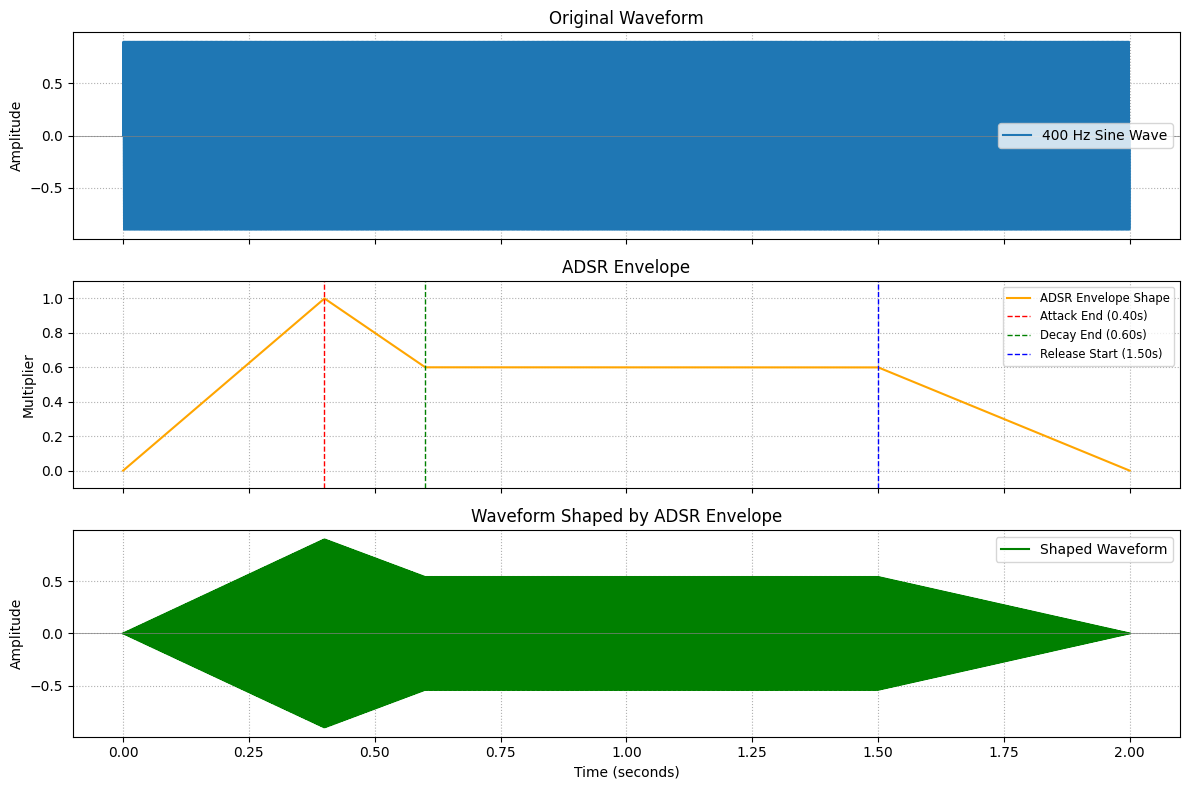

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True) # Share X axis (time)

# Plot 1: Original Wave
axs[0].plot(sample_space, original_wave, label=f'{frequency} Hz Sine Wave')
axs[0].set_title('Original Waveform')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True, linestyle=':')
axs[0].legend()
axs[0].axhline(0, color='grey', linewidth=0.5) # Zero line

# Plot 2: ADSR Envelope Shape
axs[1].plot(sample_space, envelope_shape, label='ADSR Envelope Shape', color='orange')
axs[1].set_title('ADSR Envelope')
axs[1].set_ylabel('Multiplier')
axs[1].grid(True, linestyle=':')
axs[1].legend()
axs[1].set_ylim(-0.1, 1.1) # Set Y limits for clarity

# Add vertical lines indicating phase changes on the envelope plot
total_samples = len(original_wave)
attack_samples = attack_t * sample_rate
decay_samples = decay_t * sample_rate
release_samples = release_t * sample_rate

attack_end_time = attack_samples / sample_rate
decay_end_time = (attack_samples + decay_samples) / sample_rate
release_start_time = (total_samples - release_samples) / sample_rate
release_start_time = max(decay_end_time, release_start_time) # Ensure release doesn't start before decay ends

axs[1].axvline(attack_end_time, color='r', linestyle='--', linewidth=1, label=f'Attack End ({attack_t:.2f}s)')
axs[1].axvline(decay_end_time, color='g', linestyle='--', linewidth=1, label=f'Decay End ({attack_t+decay_t:.2f}s)')
# Only show release line if it's distinct from decay end
if release_start_time > decay_end_time + (1/sample_rate): # Add small tolerance
     axs[1].axvline(release_start_time, color='b', linestyle='--', linewidth=1, label=f'Release Start ({release_start_time:.2f}s)')
axs[1].legend(fontsize='small')


# Plot 3: Shaped Wave
axs[2].plot(sample_space, shaped_wave, label='Shaped Waveform', color='green')
axs[2].set_title('Waveform Shaped by ADSR Envelope')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Amplitude')
axs[2].grid(True, linestyle=':')
axs[2].legend()
axs[2].axhline(0, color='grey', linewidth=0.5) # Zero line

# Adjust layout and display
plt.tight_layout()
plt.show()

**[E] Sanity check for ASDR values**

**[E] Max Volume right after the Attack finishes and hold it there until the Release phase begins**

### Other Envelopes

Electronic instruments can use regular or inverted ADSR envelopes to shape sound over time. Inverted envelopes reverse normal behavior: attack fades down instead of up, decay rises instead of falls.

Some instruments (like Korg MS-20) add extra controls like "hold" which is how long the envelope stays at full volume before entering the decay phase.

![hold](https://theproaudiofiles.com/wp-content/uploads/2017/07/Screen-Shot-2017-07-05-at-4.25.33-PM.png)

Modern synthesizers like Prophet'08 and Modern DAWs also allow for a delay parameter before the attack i.e DAHDSR (delay, attack, hold, decay, sustain, release) envelopes.


> 8-step envelope on Casio CZ series

![alt](https://upload.wikimedia.org/wikipedia/commons/c/c1/Casio_CZ_8stepENVchart_%28CZ-1%29.jpg)

**[E] Implement Variations: Add Delay and Hold to the Envelope Module**
